In [1]:
using ForwardDiff
using StaticArrays
using LinearAlgebra
using MathOptInterface
const MOI = MathOptInterface
using CSV, DataFrames
using PyPlot
using Distributions
using Convex
using ECOS
using COSMO
using Test
using Random
include("SEA.jl")
include("BeliefCVX.jl")

initialize_prob (generic function with 1 method)

In [2]:
function get_feasible_traj(prob)
    Cₕ = reshape(prob.θ₀, prob.nₕ+prob.mₕ, prob.nₕ)'
    Aₕ = Cₕ[:,1:prob.nₕ]
    Bₕ = Cₕ[:,prob.nₕ+1:end]
    
    # creating a dynamically feasible trajectory
    xr = [prob.x₀ for k=1:prob.h]
    xh = [prob.x̂₀ for k=1:prob.h]
    ur = [zeros(prob.mᵣ) for k=1:prob.h-1]
    diffs = [zeros(2) for k=1:prob.h-1]
    dists = []
    for k=2:prob.h
        uᵣ = ur[k-1]
        uₕ = [xh[k-1] - xr[k-1]; xh[k-1] - prob.goal]
        xr[k] = prob.robot.A*xr[k-1] + prob.robot.B*uᵣ
        xh[k] = Aₕ*xh[k-1] + Bₕ*uₕ
        diffs[k-1] = xh[k][1:2] - xr[k][1:2]
        push!(dists, norm(xh[k][1:2] - xr[k][1:2], 2))
    end    

    return xr, xh, ur
end

get_feasible_traj (generic function with 1 method)

In [3]:
function get_obj(prob)
    nᵣ, mᵣ, nₕ, mₕ = prob.sizes
    Q = zeros(nₕ+mₕ, nₕ+mₕ)
    Σ_θ = prob.msee_θ₀
    Σinds = prob.Σ_inds
    for i=1:nₕ
        for j=1:nₕ
            Σ_cij = view(Σ_θ, Σinds[i], Σinds[j])
            Q .= Q + Σ_cij 
        end
    end
    Q .= Symmetric(Q)
    return Q
end

function setup_problem(prob)
    # robot dynamics constraints
    cons = Constraint[]
    xᵣ = [Variable(prob.nᵣ) for k=1:prob.h]
    uᵣ = [Variable(prob.mᵣ) for k=1:prob.h-1]
    for k=2:prob.h
        push!(cons, xᵣ[k] == prob.robot.A*xᵣ[k-1] + prob.robot.B*uᵣ[k-1])
    end
    
    # human dynamics constraints
    C = reshape(prob.θ₀, prob.nₕ+prob.mₕ, prob.nₕ)'
    Aₕ = C[1:prob.nₕ,1:prob.nₕ]
    Bₕ = C[1:prob.nₕ,prob.nₕ+1:end]

    xₕ = [Variable(prob.nₕ) for k=1:prob.h]
    for k=1:prob.h-1
        uₕ = [xₕ[k] - xᵣ[k]; xₕ[k] - prob.goal]
        push!(cons, xₕ[k+1] == Aₕ*xₕ[k] + Bₕ*uₕ)
    end
    
    # initial state constraints
    push!(cons, xᵣ[1] == prob.x₀)
    push!(cons, xₕ[1] == prob.x̂₀)
    
    # distance constraints
    τ = [Variable(1) for k=1:prob.h-1]
    for k=1:prob.h-1
        push!(cons, norm(xᵣ[k+1] - xₕ[k+1], 2) <= τ[k])
        push!(cons, τ[k] >= prob.dmin)
    end
    
    # actuator limits
    for k=1:prob.h-1
        push!(cons, uᵣ[k] <= prob.umax*ones(prob.mᵣ))
        push!(cons, uᵣ[k] >= prob.umin*ones(prob.mᵣ))
    end
    
    # reference tracking
    uref = zeros(prob.mᵣ, prob.h-1)
    xref = zeros(prob.nᵣ, prob.h)
    xref[:,1] .= prob.x₀
    for k=1:prob.h-1
        uref[:,k] .= get_uref(prob, xref[:,k])
        xref[:,k+1] .= prob.robot.A*xref[:,k] + prob.robot.B*uref[:,k]
    end
    
    # setting active exploration objective
    Q = get_obj(prob)
    obj = [quadform([xₕ[k]; xₕ[k] - xᵣ[k]; xₕ[k] - prob.goal], Q) for k=2:prob.h]
    
    # setting reference tracking objective
    Q_ref = 10.0*I(prob.nᵣ)
    R_ref = 10.0*I(prob.mᵣ)
    Qf = 50.0*I(prob.nᵣ)
    for k=1:prob.h-1
        push!(obj, quadform(uᵣ[k] - uref[:,k], R_ref))
        push!(obj, quadform(xᵣ[k] - xref[:,k], Q_ref))
    end
    push!(obj, quadform(xᵣ[prob.h] - xref[:,prob.h], Qf))
    
    problem = minimize(sum(obj), cons)
    
    return problem, xᵣ, xₕ, uᵣ
end

setup_problem (generic function with 1 method)

In [4]:
prob = initialize_prob(h=40)
problem, xᵣ, xₕ, uᵣ = setup_problem(prob)
solve!(problem, () -> ECOS.Optimizer(max_iter=10000, verbose=true))


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.241e+03  +7e+03  3e-01  3e-01  1e+00  1e+01    ---    ---    1  2  - |  -  - 
 1  +5.764e+00  -7.449e+02  +3e+03  9e-02  6e-02  3e+00  4e+00  0.8517  3e-01   2  2  1 |  0  0
 2  -5.821e+00  -5.303e+02  +2e+03  6e-02  5e-02  2e+00  3e+00  0.5997  5e-01   1  1  1 |  0  0
 3  +2.389e+01  -1.273e+02  +5e+02  2e-02  1e-02  8e-01  8e-01  0.7650  8e-02   2  1  1 |  0  0
 4  +3.107e+01  -1.296e+02  +5e+02  2e-02  9e-03  9e-01  8e-01  0.1551  7e-01   2  2  2 |  0  0
 5  +1.019e+02  +1.385e+01  +2e+02  1e-02  3e-03  6e-01  4e-01  0.8395  3e-01   2  1  1 |  0  0
 6  +1.537e+02  +1.294e+02  +6e+01  3e-03  7e-04  2e-01  9e-02  0.8277  1e-01   2  1  1 |  0  0
 7  +1.598e+02  +1.389e+02  +4e+01  2e-03  6e-04  1e-01  7e-02  0.4274  5e-01   2  2  2 |  0  0
 8  +1.828e+02  +1.798e+02  +6e+00  3e-04  8e-

In [5]:
problem.status == MOI.OPTIMAL

true

In [6]:
# Random.seed!(123)
prob = initialize_prob(h=40)
T = 200 # number of timesteps
xᵣ = prob.x₀
xₕ = prob.x̂₀
tₛ = prob.tₛ 
Aₕ = [1 0 tₛ 0;
      0 1 0 tₛ;
      0 0 1 0;
      0 0 0 1]

B1 = 0.5 .*[0 0 0 0;
             0 0 0 0; 
             0 0 tₛ 0;
             0 0 0 tₛ]
B2 = (-0.1) .*[1 0 0 0;  
               0 1 0 0; 
               0 0 0 0;
               0 0 0 0]
Bₕ = [B1 B2]
A_true = Aₕ
B_true = Bₕ
θ_true = vec([A_true B_true]')
human = Human(A_true, B_true)
points = [0, 0]
# prob.robot_goal .= [(20 .*rand(2) .- 10); 0; 0]
prob.robot_goal .= Array{Float64}([0; 0; 0; 0])
prob.x₀ .= Array{Float64}([-1; 3; 0; 0])
prob.x̂₀ .= Array{Float64}([0; 0; 0; 0])

# storing data
all_xₕ = [xₕ zeros(prob.nₕ, T-1)]
all_xᵣ = [xᵣ zeros(prob.nᵣ, T-1)]
all_uᵣ = zeros(prob.mᵣ, T-1)
all_msee_x = zeros(prob.nₕ, prob.nₕ, T)
all_msee_x[:,:,1] .= prob.msee_x₀
all_goals = [prob.goal zeros(prob.nₕ, T-1)]

# saving metrics
pred_err = zeros(T-1)
θ_est_err = zeros(T-1)
msee_norm = zeros(T-1)
noise = MvNormal(zeros(4), 0.1I)
for k=2:T
    problem, xᵣ_var, xₕ_var, uᵣ_var = setup_problem(prob)
    solve!(problem, () -> ECOS.Optimizer(verbose=false), silent_solver=true)
    
    if problem.status == MOI.INFEASIBLE
        uᵣ = get_uref(prob)
    else
        # extract first action for the robot
        uᵣ = evaluate(uᵣ_var[1])
    end
    
    uᵣ = get_uᵣ_SEA(prob, uᵣ, true)

    # robot and human move
    uₕ = get_uₕ(prob, xₕ, xᵣ)
    xᵣ = prob.robot.A*xᵣ + prob.robot.B*uᵣ
#     xₕ_obs = human.A*xₕ + human.B*uₕ + rand(noise)
#     xₕ_true = human.A*xₕ + human.B*uₕ
    xₕ_true = nonlinear_human(prob, xₕ, xᵣ)
    xₕ_obs = xₕ_true + rand(noise)
    
    # do adaptation
    err = adapt_θ!(prob, prob.x̂₀, xₕ_obs, xᵣ, uᵣ)
    xₕ = xₕ_true
    
    game_logic(prob, points)
    
    # store data
    all_xₕ[:,k] .= xₕ
    all_xᵣ[:,k] .= xᵣ
    all_uᵣ[:,k-1] .= uᵣ
    all_msee_x[:,:,k] .= prob.msee_x₀
    all_goals[:,k] .= prob.goal
    
    # compute and store metrics
    pred_err[k-1] = err
    θ_est_err[k-1] = norm(θ_true - prob.θ₀)
    msee_norm[k-1] = norm(prob.msee_x₀)
end

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/rapandya/.julia/packages/Convex/SRJjA/src/solution.jl:250
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/rapandya/.julia/packages/Convex/SRJjA/src/solution.jl:250
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/rapandya/.julia/packages/Convex/SRJjA/src/solution.jl:250


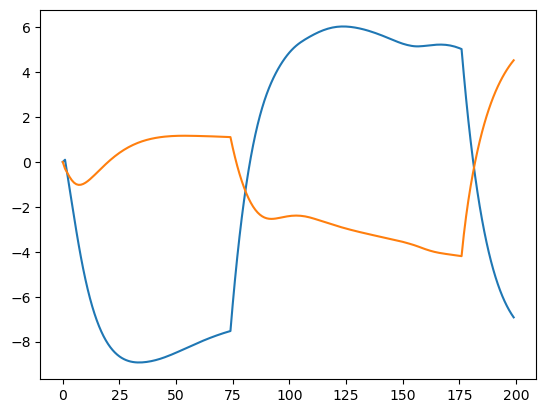

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f95dd6593d0>

In [7]:
plot(all_xₕ[1,:])
plot(all_xₕ[2,:])

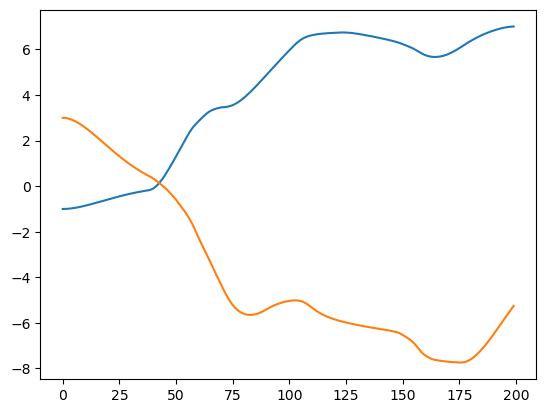

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f95dda074f0>

In [8]:
plot(all_xᵣ[1,:])
plot(all_xᵣ[2,:])

In [9]:
# save resulting trajectories to python for replay
msee_XX = zeros(prob.nₕ^2, T)
for i=1:T
    msee_XX[:,i] .= vec(all_msee_x[:,:,i])
end
# CSV.write("../data/ecos_U_active.csv", DataFrame(all_uᵣ, :auto), header=false)
# CSV.write("../data/ecos_X_active.csv", DataFrame(all_xᵣ, :auto), header = false)
# CSV.write("../data/ecos_X_hat_active.csv", DataFrame(all_xₕ, :auto), header = false)
# CSV.write("../data/ecos_msee_active.csv", DataFrame(msee_XX, :auto), header = false)

# CSV.write("../data/ecos_U.csv", DataFrame(all_uᵣ, :auto), header=false)
# CSV.write("../data/ecos_X.csv", DataFrame(all_xᵣ, :auto), header = false)
# CSV.write("../data/ecos_X_hat.csv", DataFrame(all_xₕ, :auto), header = false)
# CSV.write("../data/ecos_msee.csv", DataFrame(msee_XX, :auto), header = false)